In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from data_utils import get_segment, get_raw_segment

In [2]:
# a 16 second long segment starting at t = 20 seconds
# contains both channels
segment = get_raw_segment(start_idx=320_000, num_samples=256_000).T
segment.shape

(2, 256000)

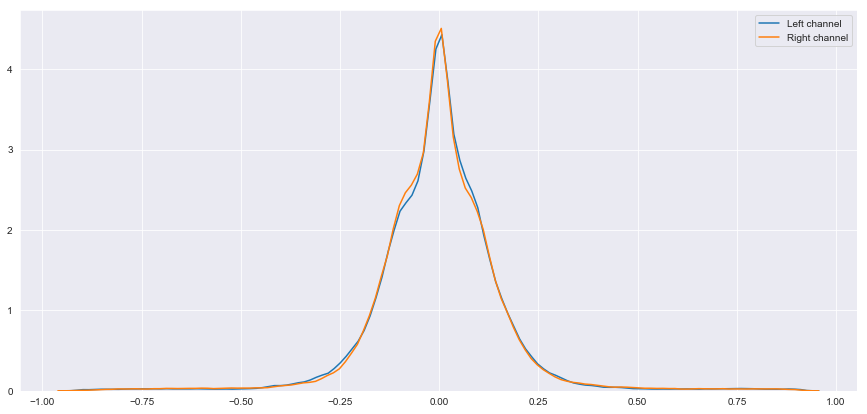

In [3]:
plt.subplots(figsize=(15, 7))
sns.kdeplot(segment[0], bw=1e-2, label='Left channel')
sns.kdeplot(segment[1], bw=1e-2, label='Right channel')
plt.legend()

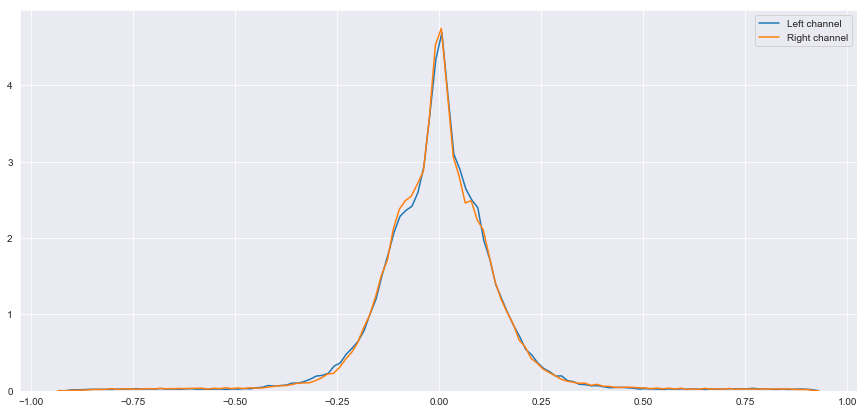

In [4]:
plt.subplots(figsize=(15, 7))
sns.kdeplot(segment[0], bw=1e-3, label='Left channel')
sns.kdeplot(segment[1], bw=1e-3, label='Right channel')
plt.legend()

In [5]:
def mu_law_compression(x, mu=255):
    """Function to perform mu-law compression, as done in the og WaveNet."""
    return np.sign(x) * np.log(1 + mu*np.absolute(x)) / np.log(1 + mu)

companded = mu_law_compression(segment, 255)

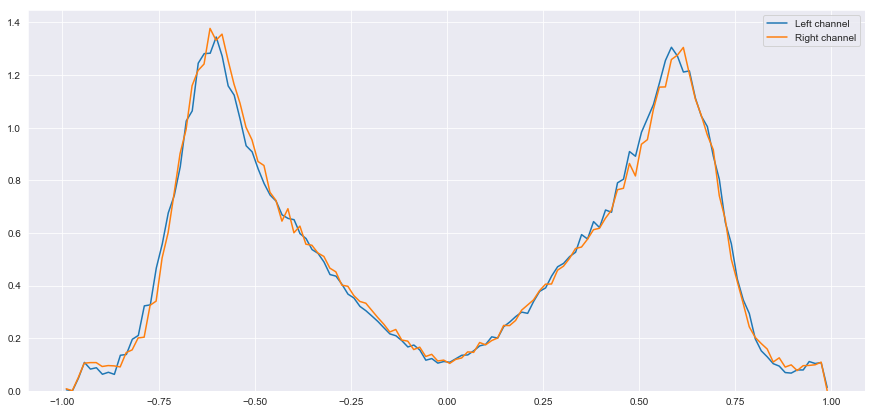

In [6]:
plt.subplots(figsize=(15, 7))
sns.kdeplot(companded[0], bw=1e-3, label='Left channel')
sns.kdeplot(companded[1], bw=1e-3, label='Right channel')
plt.legend()

Now let's look at a plot of the signals against time.

In [7]:
xs = np.linspace(320_000, 320_000 + 255_999, 256_000)

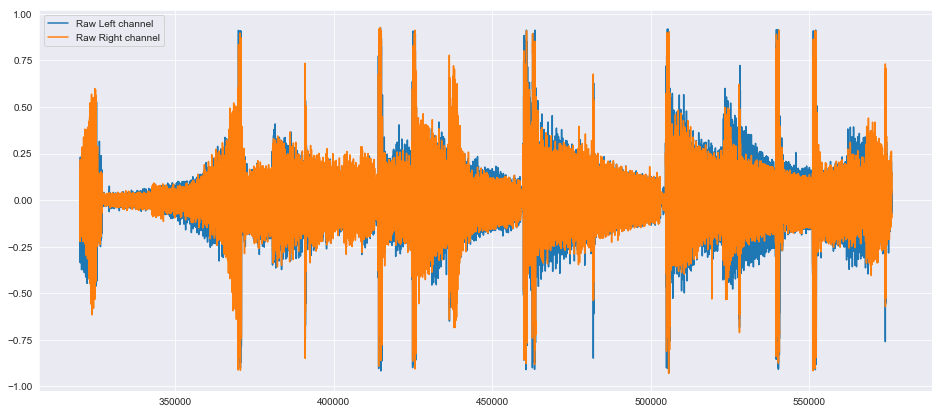

In [8]:
plt.subplots(figsize=(16, 7))
sns.lineplot(xs, segment[0], label='Raw Left channel')
sns.lineplot(xs, segment[1], label='Raw Right channel')
plt.legend()

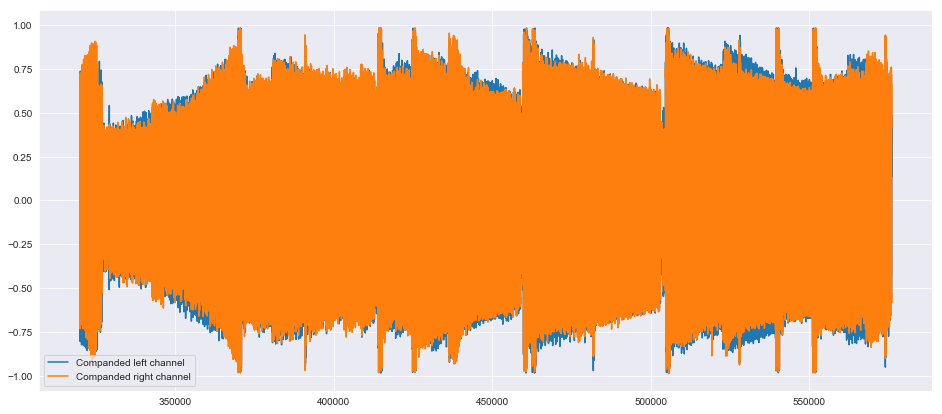

In [9]:
plt.subplots(figsize=(16, 7))
sns.lineplot(xs, companded[0], label='Companded left channel')
sns.lineplot(xs, companded[1], label='Companded right channel')
plt.legend()

Let's zoom in (and also let's only look at the left channel, since both channels are highly correlated).

In [10]:
xs_small = np.linspace(320_000, 320_639, 640)

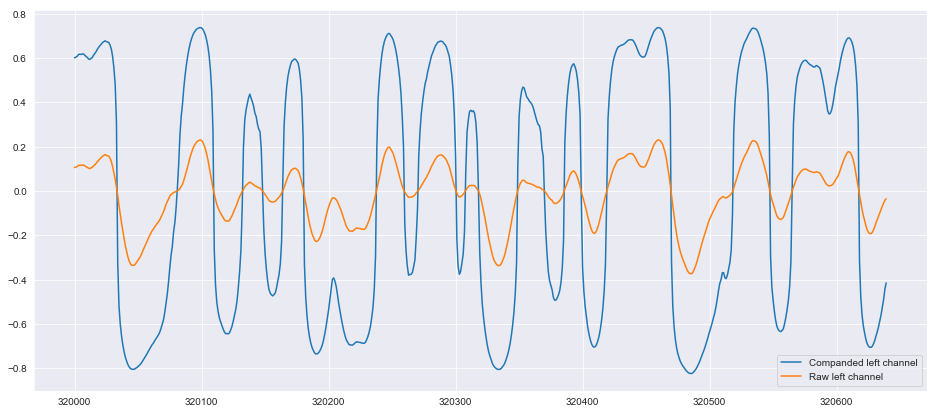

In [11]:
plt.subplots(figsize=(16, 7))
sns.lineplot(xs_small, companded[0][:640], label='Companded left channel')
sns.lineplot(xs_small, segment[0][:640], label='Raw left channel')
plt.legend()

In [12]:
def mu_law_expansion(x, mu=255):
    """Function to perform mu-law expansion, the inverse of mu-law compression."""
    return np.sign(x) * (np.power(1 + mu, np.absolute(x)) - 1) / mu

expanded = mu_law_expansion(companded)
okay = np.allclose(expanded, segment)
print(f'It is {okay} that `mu_law_expansion` is the inverse of `mu_law_compression`.')

It is True that `mu_law_expansion` is the inverse of `mu_law_compression`.


Now let's perform mu-law compression on all the input data and save it to a file so we don't have to do the same computations over and over again.

In [13]:
import os

In [15]:
MU_LAW_FILE = 'audio_training/mu_law_compressed.npy'
if not os.path.isfile(MU_LAW_FILE):
    raw_data = np.load('audio_training/channels_last.npy')
    compressed = mu_law_compression(raw_data)
    np.save(MU_LAW_FILE, compressed)